In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import json
import glob
import cv2
import imageio
import numpy as np

import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import modules.utils
import modules.pytorch_utils

import modules.Places2

from IPython.display import Image, display

# Device

In [3]:
!nvidia-smi

Fri Mar 13 00:37:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:05:00.0 Off |                  N/A |
| 40%   63C    P2    62W / 250W |   4007MiB / 12194MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            Off  | 00000000:09:00.0 Off |                  N/A |
| 23%   35C    P8     9W / 250W |     10MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [4]:
GPU_ON = True
GPU_num = 0
RANDOM_SEED = 42
DEVICE = torch.device(f"cuda:{GPU_num}" if torch.cuda.is_available() and GPU_ON else 'cpu')

# Utils.set_seed(RANDOM_SEED)
print(f"Device: {DEVICE}")
print(f"Random seed: {RANDOM_SEED}")

Device: cuda:0
Random seed: 42


# Pretrained Model
- Source: https://pytorch.org/docs/stable/torchvision/models.html

In [5]:
PRETRAINED_MODELS = {
    "resnet18"        : models.resnet18,
    "alexnet"         : models.alexnet,
    "squeezenet"      : models.squeezenet1_0,
    "vgg16"           : models.vgg16,
    "densenet"        : models.densenet161,
    "inception"       : models.inception_v3,
    "googlenet"       : models.googlenet,
    "shufflenet"      : models.shufflenet_v2_x1_0,
    "mobilenet"       : models.mobilenet_v2,
    "resnext50_32x4d" : models.resnext50_32x4d,
    "wide_resnet50_2" : models.wide_resnet50_2,
    "mnasnet"         : models.mnasnet1_0
}

In [7]:
selected_models = ['resnet18']

In [8]:
MODELS_TO_EVALUATE = { model_key : PRETRAINED_MODELS[model_key](pretrained=True) for model_key in selected_models }

## Imagenet Dataset Labels <-> Indices

In [9]:
imagenet_labels_root = "info/imagenet_class_index.json"
imagenet_idx2label = modules.utils.load_imagenet_labels(imagenet_labels_root)

# Dataset Handler
- https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [10]:
_ROOT = '/hdd/mliuzzolino/Places2/places365_standard/train'
_PREDICTED_LABELS_ROOT = '/hdd/mliuzzolino/Places2/predicted_labels'
modules.utils.make_dir(_PREDICTED_LABELS_ROOT)

_BATCH_SIZE = 64

In [11]:
imagenet_xforms = modules.pytorch_utils.load_imagenet_transformations()

In [12]:
transformations = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    imagenet_xforms['normalize']
])

In [13]:
dataset = modules.Places2.Dataset(root=_ROOT, transforms=transformations)
datahandler = DataLoader(dataset, batch_size=_BATCH_SIZE, shuffle=True)

Building image filepaths from /hdd/mliuzzolino/Places2/places365_standard/train...
Path setup complete.


### Preview Images

(-0.5, 2065.5, 2065.5, -0.5)

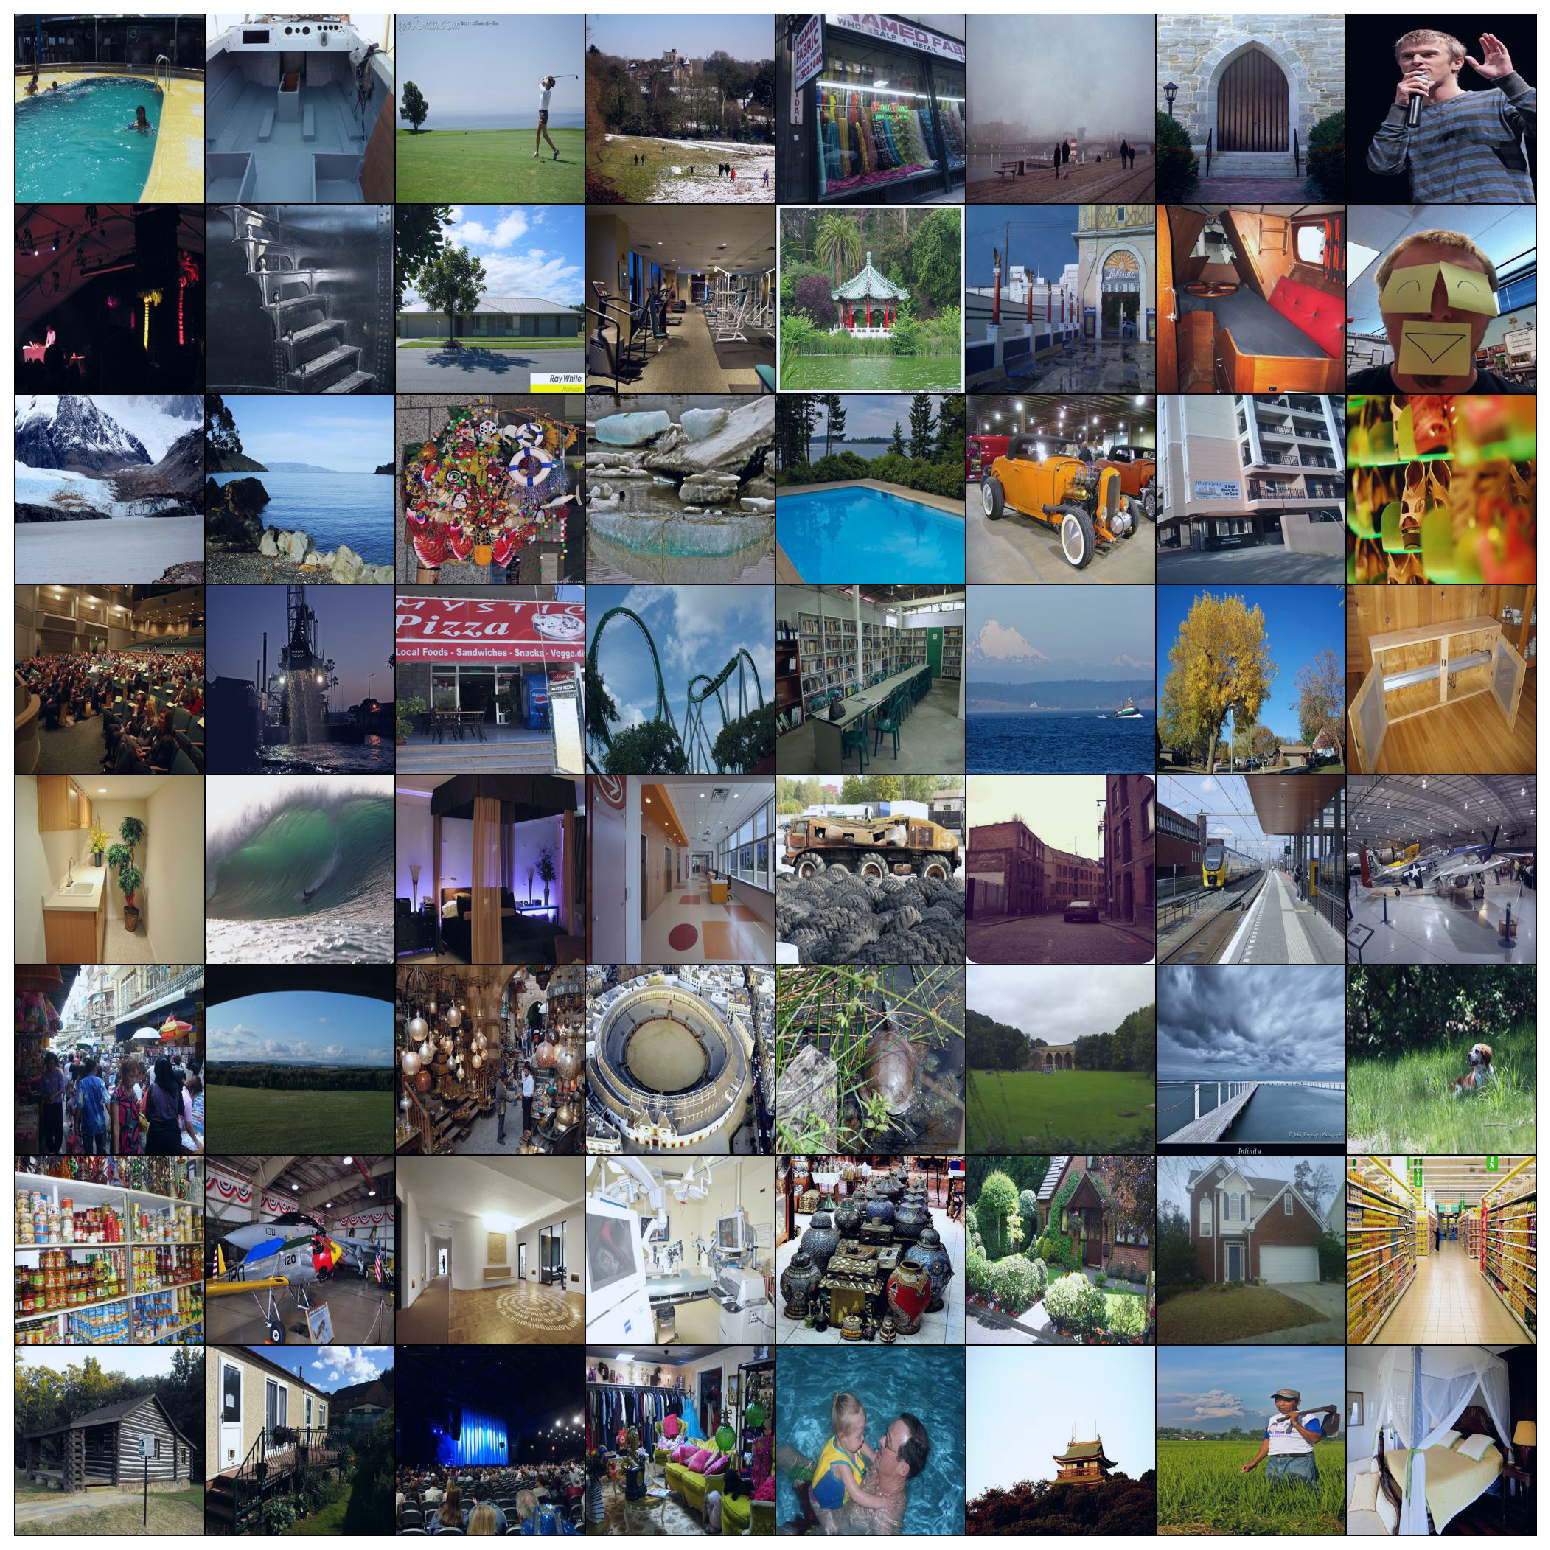

In [14]:
for i, (imgs, img_paths) in enumerate(datahandler):
    break
grid_imgs = torchvision.utils.make_grid(imgs, normalize=True).permute(1,2,0)
plt.figure(figsize=(14,14))
plt.imshow(grid_imgs)
plt.axis('off')

# Evaluate

In [15]:
EVAL_BATCH_LIMIT = None
_OVERWRITE_LOG = True

In [16]:
try:
    for model_key, pt_model in MODELS_TO_EVALUATE.items():
        
        log_path = os.path.join(_PREDICTED_LABELS_ROOT, f'{model_key}.json')
        if os.path.exists(log_path) and not _OVERWRITE_LOG:
            print(f"\n{log_path} already exists. Skipping evaluation.")
            continue
        
        pt_model = pt_model.to(DEVICE)
        pt_model.eval()
        
        model_i_predictions = []
        for i, (imgs, img_paths) in enumerate(datahandler):

            if EVAL_BATCH_LIMIT and i >= EVAL_BATCH_LIMIT:
                break
            sys.stdout.write(f"\r{model_key} -- Evaluating {i+1:,}/{len(datahandler):,}...")
            sys.stdout.flush()

            # Send to device
            imgs = imgs.to(DEVICE)

            # Inference
            with torch.no_grad():
                output = pt_model(imgs)
            predicted_labels = modules.utils.get_prediction_idxs(output).cpu()
            predictions = [(pred_idx.item(), imagenet_idx2label[pred_idx], img_paths[j]) 
                               for j, pred_idx in enumerate(predicted_labels)]

            model_i_predictions += predictions
    
        # Log to dir
        with open(log_path, 'w') as outfile:
            json.dump(model_i_predictions, outfile)
        
        # Remove model from device
        pt_model = pt_model.cpu()
        
except KeyboardInterrupt:
    print("\nEnding Early")
    # Log to dir
    log_path = os.path.join(_PREDICTED_LABELS_ROOT, f'{model_key}.json')
    with open(log_path, 'w') as outfile:
        json.dump(model_i_predictions, outfile)

resnet18 -- Evaluating 7121/28180...

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



resnet18 -- Evaluating 26909/28180...

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Preview

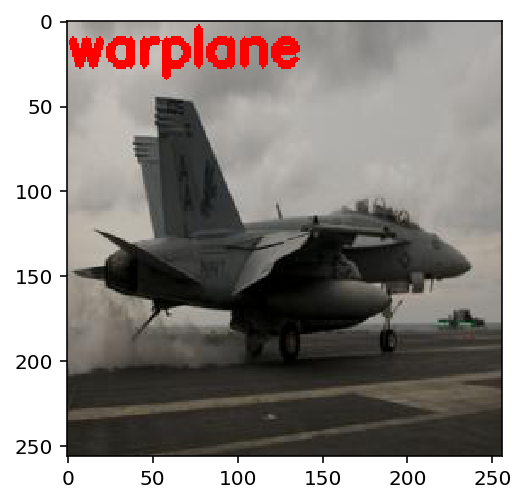

In [17]:
# Collect path of annotated labels
generated_label_paths = glob.glob(f'{_PREDICTED_LABELS_ROOT}/*')

# Load predictions
rand_path = np.random.choice(list(generated_label_paths))
with open(rand_path, 'r') as infile:
    rand_predictions = json.load(infile)

# Sample one
rand_i = np.random.choice(range(len(rand_predictions)))

# Load image, annotate, and show
pred_idx, pred_name, pred_path = rand_predictions[rand_i]
img = modules.utils.read_image(pred_path, parse_mask=False)
annotated_im = modules.utils.add_labels_to_img(img, pred_name, fontsize=1, x=0, y=25, text_color=[255,0,0])
plt.imshow(annotated_im)